In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [15]:
daily_path = ('' if IN_COLAB else '../Data/') + 'daily_strict.csv'
dailydf = pd.read_csv(daily_path, parse_dates=['date'])
dailydf['nazov'] = dailydf['nazov'].astype('category')

In [16]:
dailydf

,nazov,date,daily_pocet_do,daily_pocet_z,daily_total,zemepisna_sirka,zemepisna_dlzka,smer_do,smer_z,weekday,is_weekend,month,year
0,#1 - Starý Most,2025-02-07,172,28,200,48.110442,17.127512,Centrum,Petržalka,4,0,2,2025
1,#1 - Starý Most,2025-02-08,102,11,113,48.110442,17.127512,Centrum,Petržalka,5,1,2,2025
2,#1 - Starý Most,2025-02-09,124,25,149,48.110442,17.127512,Centrum,Petržalka,6,1,2,2025
3,#1 - Starý Most,2025-02-10,203,43,246,48.110442,17.127512,Centrum,Petržalka,0,0,2,2025
4,#1 - Starý Most,2025-02-11,195,43,238,48.110442,17.127512,Centrum,Petržalka,1,0,2,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5334,Viedenska,2025-12-03,3,129,132,48.136692,17.106380,k Staremu mostu,k Mostu SNP,2,0,12,2025
5335,Viedenska,2025-12-04,2,104,106,48.136692,17.106380,k Staremu mostu,k Mostu SNP,3,0,12,2025
5336,Viedenska,2025-12-05,1,58,59,48.136692,17.106380,k Staremu mostu,k Mostu SNP,4,0,12,2025
5337,Viedenska,2025-12-06,9,121,130,48.136692,17.106380,k Staremu mostu,k Mostu SNP,5,1,12,2025


Otázka: Sú všetky trasy vyťažené rovnako v rámci dňa?“

Hypotézy:

H₀: Medzi jednotlivými cyklotrasami neexistujú významné rozdiely v priemernej dennej vyťaženosti. (Očakávaný počet cyklistov za deň je rovnaký pre všetky cyklotrasy, parameter trasa nemá významný vplyv na strednú hodnotu.)

H₁: Medzi jednotlivými cyklotrasami existujú významné rozdiely v priemernej dennej vyťaženosti. (Očakávaný počet cyklistov za deň sa líši medzi aspoň dvoma cyklotrasami.)

## Voľba štatistického modelu pre analýzu dennej vyťaženosti cyklotrás

Výber vhodného štatistického modelu je dôležitý pre validitu záverov výskumu. V našej analýze pracujeme s dennými počtami cyklistov (daily_total) na jednotlivých trasách, čo je diskrétna nezáporná celočíselná premenná reprezentujúca počet udalostí (prejazdov bicyklov) za časovú jednotku (deň). Tento typ dát vylučuje použitie klasických metód predpokladajúcich spojitú a normálne rozdelenú závislú premennú.

Metódy ako ANOVA (analýza rozptylu) alebo lineárna regresia predpokladajú: normálne rozdelenie rezíduí, konštantný rozptyl a spojitosť závislej premennej.

Tieto predpoklady sú pri počtových dátach systematicky porušované:

- distribučná asymetria: počty sú často pravostranne šikmé s veľkým podielom nízych hodnôt,

- závislosť rozptylu na priemere: v počtových procesoch zvyčajne platí, že vyšší priemer znamená vyšší rozptyl,

- rozptyl môže výrazne prevyšovať priemer (tzv. overdispersion https://en.wikipedia.org/wiki/Overdispersion),

- diskrétnosť: hodnoty sú celé čísla, nie spojité veličiny.

Použitie nevhodných metód môže viesť k závažným chybám: skresleným odhadom, nesprávnym štandardným chybám a falošne významným p-hodnotám (zvýšená chyba I. typu).

Pre takéto typy dát je vhodné použiť generalizované lineárne modely (GLM, https://en.wikipedia.org/wiki/Generalized_linear_model) s distribúciou priamo určenou pre počty. Základný model pre analýzu počtov je Poissonova regresia, ktorá predpokladá, že závislá premenná pochádza z Poissonovho rozdelenia. Takéto modelovanie zabezpečuje, že predikované hodnoty sú vždy nezáporné. Model priamo odhaduje očakávanú dennú frekvenciu cyklistov pre každú trasu, čo zodpovedá nášmu výskumnému cieľu porovnať priemernú dennú vyťaženosť trás.

V praxi však niekedy pozorujeme, že variabilita pozorovaných denných počtov cyklistov prevyšuje priemer (tzv. overdispersion). V takýchto prípadoch Poissonov model podceňuje chyby odhadov a môže viesť k nesprávnym záverom (napr. falošne významné rozdiely). Preto sa ako alternatíva používa negatívna binomická regresia, ktorá obsahuje ďalší parameter rozptylu a umožňuje modelovať situácie, kde variancia presahuje priemer, čím poskytuje spoľahlivejšie odhady a testovanie hypotéz. (https://link.springer.com/article/10.1186/s12966-023-01460-y, https://stats.oarc.ucla.edu/stata/dae/negative-binomial-regression/)

Test sa vykoná pomocou likelihood ratio test, ktorý porovnáva model s trasami voči nulovému modelu.

V analýze sme postupovali nasledovne:

Najprv sme spravili Poissonov model, ktorý slúžil ako diagnostický nástroj na detekciu overdispersion.
Disperziu sme vypočítali ako pomer Pearson chi squared a residual degrees of freedom (https://www.askpython.com/python-modules/statsmodel/statsmodels-generalized-linear-models).
Pomer vyšiel výrazne väčší ako 1, preto sme spravili aj negatívny binomický model, lebo v prípade overdispersion Poissonov model podceňuje štandardné chyby, čo vedie k príliš úzkym intervalom spoľahlivosti a zvýšenému riziku falošnej významnosti. (https://www.reddit.com/r/statistics/comments/ttgrxl/q_why_does_overdispersion_make_coefficient/)

Použitím negatívnej binomickej regresie rozšírime Poissonov model o dodatočný parameter rozptylu, čo umožňuje rozptylu rásť nezávisle od priemeru.


In [17]:
mean_var = dailydf.groupby('nazov', observed=False)['daily_total'].agg(['mean', 'var'])
mean_var['var_to_mean'] = mean_var['var'] / mean_var['mean']
mean_var

,mean,var,var_to_mean
nazov,,,
#1 - Starý Most,635.163701,1.293718e+05,203.682668
#10 - Dunajská,392.758007,4.421461e+04,112.574676
#11 - Most Apollo,601.587189,1.940689e+05,322.594779
#12 - Železná studnička,615.825623,3.036728e+05,493.114965
#15 - Incheba Einsteinova,409.975089,6.856299e+04,167.236963
#16 - Trenčianska,596.725979,8.744015e+04,146.533171
#17 - Dunajská/Lazaretská,413.427046,4.628015e+04,111.942714
#2 - Starý most 2,547.932384,1.116778e+05,203.816791
#3 - River Park,1010.334520,4.432771e+05,438.742855


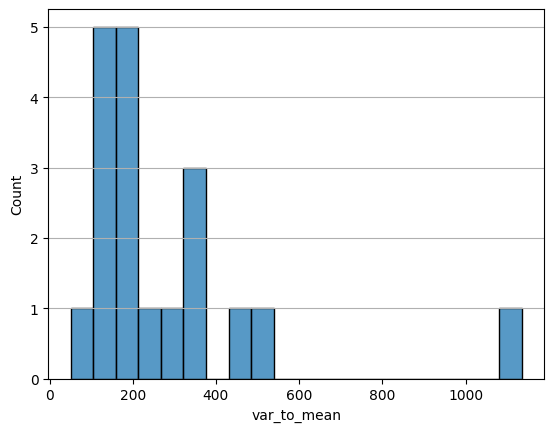

In [18]:
sns.histplot(mean_var['var_to_mean'], bins=20)
plt.grid(axis='y')

Kľúčovým predpokladom Poissonovej regresie je, že rozptyl odpovedajúcej premennej sa rovná jej priemeru. Na posúdenie tohto predpokladu sme vypočítali pomer rozptylu k priemeru pre denný počet cyklistov na každej trase. Pre všetky trasy rozptyl denných počtov výrazne prekročil priemer (pomer rozptylu k priemeru > 50), čo naznačuje podstatnú nadmernú disperziu v porovnaní s Poissonovým predpokladom. Taký veľký pomer disperzie naznačuje, že Poissonov model by podhodnocoval skutočnú variabilitu a viedol by k skresleným štandardným chybám a nespoľahlivým p-hodnotám. Preto sme sa rozhodli použiť aj negatívnu binomickú regresiu, ktorá je zovšeobecnením Poissonovej regresie, ktorá pridáva parameter disperzie, aby vhodnejšie modelovala vyššiu variabilitu v údajoch a poskytovala lepšie štatistické závery.

In [19]:
poisson_model = smf.glm(
    formula='daily_total ~ nazov',
    data=dailydf,
    family=sm.families.Poisson()
).fit()

print('Poisson:')
# https://www.askpython.com/python-modules/statsmodel/statsmodels-generalized-linear-models
print(f"Deviance: {poisson_model.deviance:.2f}")
print(f"Pearson chi2: {poisson_model.pearson_chi2:.2f}")
print(f"DF Residuals: {poisson_model.df_resid:.2f}")

dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
print(f"Dispersion: {dispersion:.2f}")

Poisson:
Deviance: 1534735.05
Pearson chi2: 1494841.62
DF Residuals: 5320.00
Dispersion: 280.99


In [20]:
nb_model = smf.glm(
    formula='daily_total ~ nazov',
    data=dailydf,
    family=sm.families.NegativeBinomial()
).fit()

print('Negative binomial:')
print(f"Deviance: {nb_model.deviance:.2f}")
print(f"Pearson chi2: {nb_model.pearson_chi2:.2f}")
print(f"DF Residuals: {nb_model.df_resid:.2f}")

dispersion = nb_model.pearson_chi2 / nb_model.df_resid
print(f"Dispersion: {dispersion:.2f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Negative binomial:
Deviance: 4694.67
Pearson chi2: 3025.58
DF Residuals: 5320.00
Dispersion: 0.57


In [21]:
display(poisson_model.summary())
display(nb_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            daily_total   No. Observations:                 5339
Model:                            GLM   Df Residuals:                     5320
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.8746e+05
Date:                Tue, 06 Jan 2026   Deviance:                   1.5347e+06
Time:                        19:02:17   Pearson chi2:                 1.49e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              6.4539      0.002   2726.573      0.000       6.449       6.459
nazov[T.#10 - Dunajská]               -0.4807      0.004   -125.529      0.000      -0.488      -0.473
nazov[T.#11 - Most Apollo]            -0.0543      0.003    -16.003      0.000      -0.061      -0.048
nazov[T.#12 - Železná studnička]      -0.0309      0.003     -9.165      0.000      -0.038      -0.024
nazov[T.#15 - Incheba Einsteinova]    -0.4378      0.004   -115.838      0.000      -0.445      -0.430
nazov[T.#16 - Trenčianska]            -0.0624      0.003    -18.355      0.000      -0.069      -0.056
nazov[T.#17 - Dunajská/Lazaretská]    -0.4294      0.004   -113.909      0.000      -0.437      -0.422
nazov[T.#2 - Starý most 2]            -0.1477      0.003    -42.474      0.000      -0.155      -0.141
nazov[T.#3 - River Park]               0.4642      0.003    153.653      0.000       0.458       0.470
nazov[T.#4 - Dolnozemská]              0.9692      0.003    348.617      0.000       0.964       0.975
nazov[T.#5 - Devínska cesta]          -1.8483      0.006   -288.039      0.000      -1.861      -1.836
nazov[T.#8 - Most SNP]                -0.2128      0.004    -60.118      0.000      -0.220      -0.206
nazov[T.#9 - Páričkova]               -0.1231      0.003    -35.632      0.000      -0.130      -0.116
nazov[T.Cyklomost Slobody]            -0.6400      0.004   -158.867      0.000      -0.648      -0.632
nazov[T.Devinska Nova Ves]            -1.3237      0.005   -256.394      0.000      -1.334      -1.314
nazov[T.Hradza Berg]                  -0.7252      0.004   -174.989      0.000      -0.733      -0.717
nazov[T.Vajanského_combined]           0.1909      0.003     59.688      0.000       0.185       0.197
nazov[T.Vajnorská_combined]           -0.9911      0.005   -217.851      0.000      -1.000      -0.982
nazov[T.Viedenska]                     0.0483      0.003     14.611      0.000       0.042       0.055
======================================================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            daily_total   No. Observations:                 5339
Model:                            GLM   Df Residuals:                     5320
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -38164.
Date:                Tue, 06 Jan 2026   Deviance:                       4694.7
Time:                        19:02:17   Pearson chi2:                 3.03e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2922
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              6.4539      0.060    108.102      0.000       6.337       6.571
nazov[T.#10 - Dunajská]               -0.4807      0.084     -5.692      0.000      -0.646      -0.315
nazov[T.#11 - Most Apollo]            -0.0543      0.084     -0.643      0.520      -0.220       0.111
nazov[T.#12 - Železná studnička]      -0.0309      0.084     -0.366      0.714      -0.196       0.135
nazov[T.#15 - Incheba Einsteinova]    -0.4378      0.084     -5.184      0.000      -0.603      -0.272
nazov[T.#16 - Trenčianska]            -0.0624      0.084     -0.739      0.460      -0.228       0.103
nazov[T.#17 - Dunajská/Lazaretská]    -0.4294      0.084     -5.085      0.000      -0.595      -0.264
nazov[T.#2 - Starý most 2]            -0.1477      0.084     -1.750      0.080      -0.313       0.018
nazov[T.#3 - River Park]               0.4642      0.084      5.498      0.000       0.299       0.630
nazov[T.#4 - Dolnozemská]              0.9692      0.084     11.482      0.000       0.804       1.135
nazov[T.#5 - Devínska cesta]          -1.8483      0.085    -21.845      0.000      -2.014      -1.682
nazov[T.#8 - Most SNP]                -0.2128      0.084     -2.521      0.012      -0.378      -0.047
nazov[T.#9 - Páričkova]               -0.1231      0.084     -1.458      0.145      -0.289       0.042
nazov[T.Cyklomost Slobody]            -0.6400      0.084     -7.577      0.000      -0.806      -0.474
nazov[T.Devinska Nova Ves]            -1.3237      0.085    -15.661      0.000      -1.489      -1.158
nazov[T.Hradza Berg]                  -0.7252      0.084     -8.585      0.000      -0.891      -0.560
nazov[T.Vajanského_combined]           0.1909      0.084      2.261      0.024       0.025       0.356
nazov[T.Vajnorská_combined]           -0.9911      0.084    -11.731      0.000      -1.157      -0.826
nazov[T.Viedenska]                     0.0483      0.084      0.572      0.567      -0.117       0.214
======================================================================================================
"""

Na posúdenie rozdielov v očakávanom dennom počte cyklistov na jednotlivých trasách sme najprv použili Poissonov model. Diagnostika tohto modelu odhalila extrémnu overdisperziu (280.99), čo znamená, že variabilita v dátach výrazne prevyšovala variabilitu predpokladanú Poissonovým rozdelením, kde stredná hodnota = rozptyl. V takomto prípade Poissonov model podceňuje štandardné chyby odhadov, čo vedie k nespoľahlivým štatistickým testom a zvýšenému riziku falošnej významnosti (chyba I. typu).

Preto sme ako vhodnejší prístup použili negatívnu binomickú regresiu. Tento model zavádza dodatočný parameter rozptylu, ktorý explicitne modeluje nadmernú variabilitu (overdisperziu). Po jeho aplikácii sa disperzia znížila na 0.57, čo potvrdilo, že negatívny binomický model adekvátne zachytáva variabilitu v našich dátach a je pre ďalšiu inferenciu štatisticky správnou voľbou.


Koeficienty oboch modelov sa interpretujú rovnako: predstavujú rozdiel v logaritme očakávaného denného počtu (log(počet)) medzi danou trasou a referenčnou trasou. Ich exponenciála (exp(koeficient)) má multiplikatívny efekt, teda koľkokrát je očakávaný počet na trase vyšší alebo nižší v porovnaní s referenčnou trasou. V našej analýze mal približný denný počet na referenčnej trase hodnotu 635 cyklistov.

Príklad interpretácie: Ak model pre konkrétnu trasu odhadne koeficient 0.97, znamená to, že log(očakávaný_počet) je 0.97 krát vyšší ako na referenčnej trase. Prevod exp(0.97) = 2.64 znamená, že očakávaný denný počet na tejto trase je približne 2.64-násobkom počtu na referenčnej trase, čo predstavuje približne 635 * 2.64 = 1676 cyklistov za deň. Záporný koeficient naopak značí nižšiu vyťaženosť v porovnaní s referenčnou trasou.

Pri porovnaní modelov sme pozorovali, že bodové odhady koeficientov (tj. samotné hodnoty efektov trás) boli v Poissonovom aj negatívnom binomickom modeli veľmi podobné. To je očakávané, pretože oba modely cielené odhadujú rovnakú strednú hodnotu (priemerný denný počet).

Kľúčový a rozhodujúci rozdiel medzi modelmi sa týka istoty týchto odhadov, ktorú vyjadrujú štandardné chyby. Poissonov model, ktorý nútene predpokladá nízku variabilitu, produkuje umelo nízke štandardné chyby. To vedie k extrémne vysokým absolútnym hodnotám testových štatistík (z-hodnôt) a následne k neprimerane nízkym p-hodnotám, ktoré by mohli nesprávne naznačovať štatistickú významnosť. Negatívny binomický model, ktorý korektne zohľadňuje overdisperziu prítomnú v dátach, poskytuje realisticky vyššie a spoľahlivejšie štandardné chyby. V dôsledku toho sú z-hodnoty, p-hodnoty a intervaly spoľahlivosti z tohto modelu spoľahlivejšie a tvoria základ pre naše závery o rozdieloch medzi trasami.


In [22]:
coef = nb_model.params
ci = nb_model.conf_int()
exp_coef = np.exp(coef)
exp_ci = np.exp(ci)

results_df = pd.DataFrame({
    'route': exp_coef.index,
    'expected': exp_coef.values,
    'CI_lower': exp_ci[0].values,
    'CI_upper': exp_ci[1].values
})

print(results_df)


                                 route    expected    CI_lower    CI_upper
0                            Intercept  635.163701  565.024509  714.009606
1              nazov[T.#10 - Dunajská]    0.618357    0.524027    0.729667
2           nazov[T.#11 - Most Apollo]    0.947137    0.802682    1.117590
3     nazov[T.#12 - Železná studnička]    0.969554    0.821681    1.144039
4   nazov[T.#15 - Incheba Einsteinova]    0.645464    0.547001    0.761650
5           nazov[T.#16 - Trenčianska]    0.939484    0.796195    1.108560
6   nazov[T.#17 - Dunajská/Lazaretská]    0.650898    0.551607    0.768062
7           nazov[T.#2 - Starý most 2]    0.862663    0.731086    1.017920
8             nazov[T.#3 - River Park]    1.590668    1.348100    1.876882
9            nazov[T.#4 - Dolnozemská]    2.635743    2.233842    3.109951
10        nazov[T.#5 - Devínska cesta]    0.157513    0.133443    0.185923
11              nazov[T.#8 - Most SNP]    0.808282    0.684996    0.953757
12             nazov[T.#9

## Porovnanie s nulovým modelom

Na formálne overenie štatistickej významnosti rozdielov medzi trasami sme vykonali LRT (Likelihood Ratio Test). Táto metóda porovnáva negatívny binomický model, ktorý obsahuje trasu ako kategorickú premennú (daily_total ~ nazov), s jednoduchým nulovým modelom (daily_total ~ 1), ktorý predpokladá, že všetky trasy majú rovnakú priemernú dennú vyťaženosť. Logika testu spočíva v posúdení, či komplexnejší model prináša zlepšenie v schopnosti vysvetliť variabilitu v dátach.

LRT sme vypočítali ako dvojnásobok rozdielu medzi logaritmami vierohodnosti (log-likelihood) oboch modelov: LR = 2 * (llf_nb_model - llf_null_nb_model). Logaritmus vierohodnosti (llf) je mierou toho, ako dobre konkrétny model vysvetľuje pozorované dáta; vyššia hodnota znamená lepší výsledok. Podľa Wilksovej vety (https://en.wikipedia.org/wiki/Wilks%27_theorem) má táto testovacia štatistika, za platnosti nulovej hypotézy a pri dostatočne veľkej vzorke, asymptoticky chí-kvadrát rozdelenie s počtom stupňov voľnosti rovným rozdielu v počte parametrov medzi modelmi.

Výsledok testu bol jednoznačný, hodnota LRT štatistiky dosiahla 1844.78 pri 17 stupňoch voľnosti (čo zodpovedá 17 nezávislým porovnaniam medzi 18 trasami). Zodpovedajúca p-hodnota bola menšia ako 0.001, v praxi v podstate nulová. Tento výsledok prevyšuje kritickú hodnotu pre štandardnú hladinu významnosti 0.05 a poskytuje dôvod na zamietnutie nulovej hypotézy. Zahrnutie premennej trasa do modelu poskytuje štatisticky významne lepšie vysvetlenie variabilít v denných počtoch cyklistov. Existujú štatisticky významné rozdiely v priemernej dennej vyťaženosti medzi analyzovanými cyklotrasami, čo potvrdzuje našu alternatívnu hypotézu H1.


In [23]:
null_nb = smf.glm(
    "daily_total ~ 1",
    data=dailydf,
    family=sm.families.NegativeBinomial()
).fit()

lr_stat = 2 * (nb_model.llf - null_nb.llf)
df_diff = nb_model.df_model - null_nb.df_model

p_value = stats.chi2.sf(lr_stat, df_diff)
print("LR statistic:", lr_stat)
print("Degrees of freedom:", df_diff)
print("p-value:", p_value)

LR statistic: 1844.7800672709127
Degrees of freedom: 18
p-value: 0.0


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [24]:
null_poisson = smf.glm(
    "daily_total ~ 1",
    data=dailydf,
    family=sm.families.Poisson()
).fit()

lr_stat = 2 * (poisson_model.llf - null_poisson.llf)
df_diff = poisson_model.df_model - null_poisson.df_model

p_value = stats.chi2.sf(lr_stat, df_diff)
print("LR statistic:", lr_stat)
print("Degrees of freedom:", df_diff)
print("p-value:", p_value)

LR statistic: 961094.9198446386
Degrees of freedom: 18
p-value: 0.0


/tmp/ipython-input-2774062251.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  route_means = dailydf.groupby('nazov')['daily_total'].mean().sort_values(ascending=False)


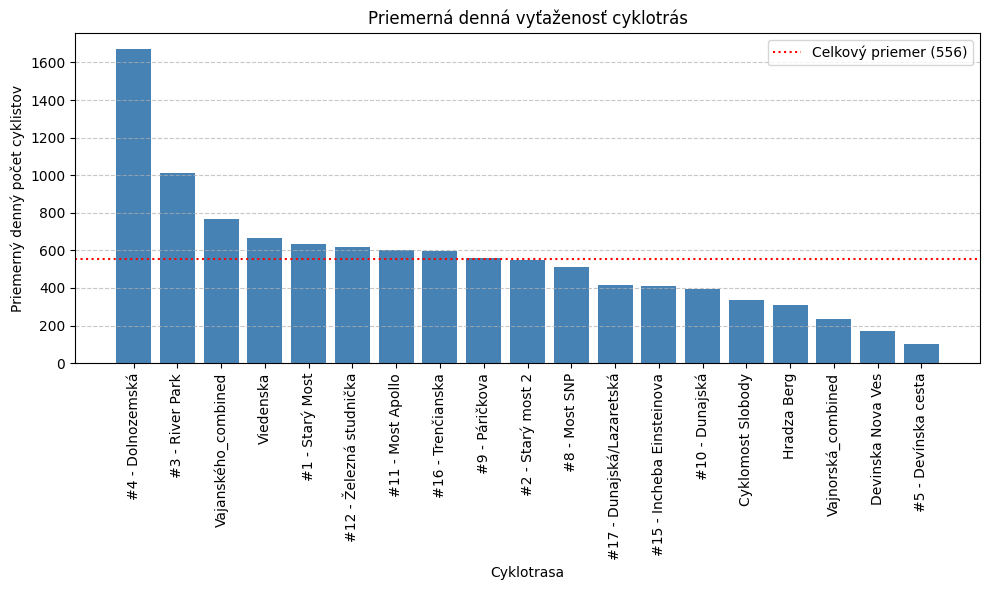

Top 3 najvyťaženejších trás:


,daily_total
nazov,
#4 - Dolnozemská,1674.1
#3 - River Park,1010.3
Vajanského_combined,768.8



Top 3 najmenej vyťažených trás:


,daily_total
nazov,
#5 - Devínska cesta,100.0
Devinska Nova Ves,169.0
Vajnorská_combined,235.7



Celkový priemer všetkých trás: 555.6 cyklistov/deň
Rozdiel medzi najviac a najmenej frekventovanou trasou: 1574 cyklistov/deň


In [25]:
route_means = dailydf.groupby('nazov')['daily_total'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(route_means)), route_means.values, color='steelblue')

plt.xticks(range(len(route_means)), route_means.index, rotation=90)
plt.ylabel('Priemerný denný počet cyklistov')
plt.xlabel('Cyklotrasa')
plt.title('Priemerná denná vyťaženosť cyklotrás')
plt.grid(axis='y', linestyle='--', alpha=0.7)

overall_mean = dailydf['daily_total'].mean()
plt.axhline(y=overall_mean, color='red', linestyle=':', label=f'Celkový priemer ({overall_mean:.0f})')
plt.legend()
plt.tight_layout()
plt.show()

print("Top 3 najvyťaženejších trás:")
display(route_means.head(3).round(1))

print("\nTop 3 najmenej vyťažených trás:")
display(route_means.tail(3).sort_values().round(1))

print(f"\nCelkový priemer všetkých trás: {overall_mean:.1f} cyklistov/deň")
print(f"Rozdiel medzi najviac a najmenej frekventovanou trasou: {route_means.iloc[0] - route_means.iloc[-1]:.0f} cyklistov/deň")

Výsledky štatistického testu sú pozorovateľné aj graficky, na grafe vidíme veľké rozdiely v priemernom dennom počte cyklistov. Najfrekventovanejšia trasa Dolnozemská má mnohonásobne vyšší priemerný denný počet cyklistov ako najmenej frekventovaná Devínska cesta.